# Create Pivot Tables

Create a pivot table of patients and conditions. Then combine all individuals and their variants into a single table for analysis.

In [1]:
import pandas as pd
import sqlalchemy as sa
from openpyxl.cell import Cell
from sqlalchemy import text

In [2]:
# read db connection from .env file
from helpers.settings import get_settings

settings = get_settings()

Loading settings ...


In [3]:
engine = sa.create_engine(settings.postgresql_dsn.__str__())

## Conditions

In [4]:
df = pd.read_sql(
    """
SELECT i.individual_id, c.condition, ic.has_condition
FROM individual i
JOIN individual_condition ic
ON i.individual_id = ic.individual_id
JOIN condition c
ON ic.condition_id = c.condition_id
""",
    engine,
)
df.head()

,individual_id,condition,has_condition
0,1,Heart Structure Abnormality,False
1,1,Baseline/resting electrocardiogram abnormality,False
2,1,Polymorphic ventricular tachycardia,True
3,1,Exercise/stress induced polymorphic ventricula...,True
4,2,Heart Structure Abnormality,False


In [5]:
df["individual_id"].min()

np.int64(1)

In [6]:
df2 = df.copy()
df2 = df2.pivot(index="individual_id", columns="condition",
                values="has_condition")
df2.reset_index(inplace=True)

df2.head()

condition,individual_id,Adult-onset primary generalised epilepsy,Arrhythmia at rest,Arrhythmogenic right ventricular cardiomyopathy,Arteriovenous malformation,Ascending aortic aneurysm,Atrial fibrillation,Atrial flutter,Atrial standstill,Atrial tachycardia,...,Sudden cardiac death,Sudden infant death syndrome,Supraventricular tachycardia,Syncope,Syncope exercise/stress induced,Third-degree atrioventricular block,Unspecified premature ventricular contractions,Ventricular fibrillation,Ventricular tachycardia (unspecified),Weight loss
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,False,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,...,NaN,NaN,NaN,True,True,NaN,False,NaN,NaN,NaN
3,4,NaN,False,NaN,NaN,NaN,False,NaN,NaN,True,...,NaN,NaN,NaN,False,NaN,NaN,False,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df2["Catecholaminergic polymorphic ventricular tachycardia 1"].value_counts()

Catecholaminergic polymorphic ventricular tachycardia 1
True    968
Name: count, dtype: int64

In [8]:
# print num rows and num unique ids
print(len(df2), df2["individual_id"].nunique())

1347 1347


In [9]:
# set the index to individual_id
df2.set_index("individual_id", inplace=True)

In [10]:
# find the current working directory
import os
import IPython

notebook_path = IPython.get_ipython().getoutput('pwd')[0]

data_dir = os.path.join(notebook_path, '..', 'data')

if not os.path.exists(data_dir):
    print(f'Creating directory: {data_dir}')
    os.makedirs(data_dir)

In [11]:
# save to csv
df_file = os.path.join(data_dir, "individual_conditions.csv")
df2.to_csv(df_file, index=False)

Combine with rest of condition data

In [12]:
df_all_condition = pd.read_sql(
    """
SELECT i.individual_id, c.condition, ic.age_of_onset, ic.description, ic.onset_symptoms, ic.age_of_presentation
FROM individual i
LEFT JOIN individual_condition ic
ON i.individual_id = ic.individual_id
LEFT JOIN condition c
ON ic.condition_id = c.condition_id
""",
    engine,
)
df_all_condition.head()

,individual_id,condition,age_of_onset,description,onset_symptoms,age_of_presentation
0,1,Heart Structure Abnormality,NaN,None,None,NaN
1,1,Baseline/resting electrocardiogram abnormality,NaN,None,None,NaN
2,1,Polymorphic ventricular tachycardia,NaN,None,None,NaN
3,1,Exercise/stress induced polymorphic ventricula...,NaN,None,None,NaN
4,2,Heart Structure Abnormality,NaN,None,None,NaN


In [13]:
df_all_condition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13687 entries, 0 to 13686
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   individual_id        13687 non-null  int64  
 1   condition            13687 non-null  object 
 2   age_of_onset         411 non-null    float64
 3   description          260 non-null    object 
 4   onset_symptoms       313 non-null    object 
 5   age_of_presentation  655 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 641.7+ KB


In [14]:
df_all_condition.groupby("individual_id")["description"].apply(
    lambda x: ", ".join(x.dropna())
).reset_index()

,individual_id,description
0,1,
1,2,
2,3,
3,4,
4,5,
...,...,...
1342,1350,2:1 noncompaction
1343,1352,
1344,1353,Abnormal RV relaxation
1345,1354,Prominent left ventricular trabeculation


In [15]:
df3_pivot = df_all_condition.pivot(
    index="individual_id",
    columns="condition",
    values=["age_of_onset", "onset_symptoms", "age_of_presentation"],
)
df3_pivot.reset_index(inplace=True)
# drop any columns that are all NaN
df3_pivot = df3_pivot.dropna(axis=1, how="all")
df3_pivot.columns = [
    "::".join(col).strip().strip(":") for col in df3_pivot.columns.values
]
# reset individual_id to a column
df3_pivot.set_index("individual_id", inplace=True)
# join the description column
df3_pivot = df3_pivot.join(
    df_all_condition.groupby("individual_id")["description"]
    .apply(lambda x: ", ".join(x.dropna()))
    .reset_index()
    .set_index("individual_id")
)
# rename the description column to "other conditions"
df3_pivot.rename(columns={"description": "other conditions"}, inplace=True)
df3_pivot.head()

,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1,onset_symptoms::Catecholaminergic polymorphic ventricular tachycardia 1,age_of_presentation::Catecholaminergic polymorphic ventricular tachycardia 1,other conditions
individual_id,,,,
1,NaN,None,36.0,
2,NaN,none,41.0,
3,NaN,None,16.0,
4,2.0,None,NaN,
5,10.0,None,28.0,


In [16]:
# save to csv
df3_pivot.to_csv(
    os.path.join(data_dir, "individual_conditions_descriptions.csv"),
    index=False
)

## Family History Conditions

In [17]:
df4_pre = pd.read_sql(
    """
SELECT i.individual_id,
       c.condition,
       fmh.has_condition,
       kn.name AS relationship
FROM individual i
         LEFT JOIN family_history_record fhr
                   ON i.individual_id = fhr.individual_id
         LEFT JOIN condition c
                   ON fhr.condition_id = c.condition_id
         JOIN family_member_history fmh
                   ON fhr.family_history_record_id =
                      fmh.family_history_record_id
         JOIN kinship_name kn
                   ON fmh.kinship_name_id = kn.kinship_name_id
ORDER BY i.individual_id
""",
    engine,
)
df4_pre.head()

,individual_id,condition,has_condition,relationship
0,1,Sudden cardiac death,True,Mother
1,1,Sudden cardiac death,False,Father
2,10,Sudden cardiac death,False,Father
3,10,Sudden cardiac death,True,Mother
4,11,Sudden cardiac death,False,Father


In [18]:
df4_1_pivot = df4_pre.pivot(
    index="individual_id", columns=["condition", "relationship"],
    values="has_condition"
)
df4_1_pivot.reset_index(inplace=True)
df4_1_pivot.columns = [
    "::".join(col).strip().strip(":") for col in df4_1_pivot.columns.values
]
df4_1_pivot.set_index("individual_id", inplace=True)
df4_1_pivot.head()

,Sudden cardiac death::Mother,Sudden cardiac death::Father
individual_id,,
1,True,False
10,True,False
11,True,False
14,True,False
15,True,False


In [19]:
df4_2_pre = pd.read_sql(
    """
SELECT i.individual_id,
       c.condition,
       num_family_members
FROM individual i
         JOIN family_history_record fhr
                   ON i.individual_id = fhr.individual_id
         JOIN condition c
                   ON fhr.condition_id = c.condition_id
WHERE num_family_members IS NOT NULL
ORDER BY num_family_members DESC
""",
    engine,
)
df4_2_pre.head()

,individual_id,condition,num_family_members
0,881,Sudden cardiac death,36
1,877,Sudden cardiac death,36
2,875,Sudden cardiac death,36
3,873,Sudden cardiac death,36
4,871,Sudden cardiac death,36


In [20]:
df4_2_pivot = df4_2_pre.pivot(
    index="individual_id", columns="condition", values="num_family_members"
).reset_index()
df4_2_pivot.columns = [
    f"{col}::num_family_members" if col != "individual_id" else col
    for col in df4_2_pivot.columns.values
]
df4_2_pivot.set_index("individual_id", inplace=True)
df4_2_pivot.head()

,Sudden cardiac death::num_family_members
individual_id,
4,0
9,0
13,0
14,0
15,0


In [21]:
# combine the two dataframes - not all individuals will be in both
df4_pivot = df4_1_pivot.join(df4_2_pivot, how="outer")
df4_pivot.head()

,Sudden cardiac death::Mother,Sudden cardiac death::Father,Sudden cardiac death::num_family_members
individual_id,,,
1,True,False,NaN
4,NaN,NaN,0.0
9,NaN,NaN,0.0
10,True,False,NaN
11,True,False,NaN


In [22]:
# save to csv
df4_pivot.to_csv(
    os.path.join(data_dir, "individual_family_conditions.csv"),
)

## Treatments

In [23]:
df5 = pd.read_sql(
    """
SELECT i.individual_id,
       tr.treatment_taken,
       tr.effective,
       t.treatment_name
FROM individual i
         JOIN treatment_record tr
                   ON i.individual_id = tr.patient_id
         LEFT JOIN treatment t
                   ON tr.treatment_id = t.treatment_id
ORDER BY i.individual_id
""",
    engine,
)
df5.head()

,individual_id,treatment_taken,effective,treatment_name
0,2,True,False,Beta blocker
1,2,False,None,Verapamil
2,2,True,True,Flecainide
3,2,False,None,Enalapril
4,2,False,None,Left cardiac sympathetic denervation


In [24]:
df5_pivot = df5.pivot(
    index="individual_id",
    columns="treatment_name",
    values=["treatment_taken", "effective"],
)
df5_pivot.reset_index(inplace=True)
df5_pivot.columns = [
    "::".join(col).strip().strip(":") for col in df5_pivot.columns.values
]
df5_pivot.set_index("individual_id", inplace=True)
df5_pivot.head()

,treatment_taken::Beta blocker,treatment_taken::Catheter ablation,treatment_taken::Enalapril,treatment_taken::Flecainide,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
individual_id,,,,,,,,,,,,,,
2,True,False,False,True,False,False,False,False,None,None,True,None,None,None
4,True,False,False,False,False,False,False,None,None,None,None,None,None,None
6,False,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
7,False,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
8,False,False,False,False,True,False,False,None,None,None,None,True,None,None


In [25]:
# save to csv
df5_pivot.to_csv(
    os.path.join(data_dir, "individual_treatments.csv"),
)

# Combine all data

In [26]:
df_rest = pd.read_sql(
    """
SELECT i.individual_id,
       ioer.original_row,
       iis.value              AS sex,
       iv.variant_id,
       z.zygosity,
       vi.variant_inheritance AS inheritance,
       v.hgvs_string,
       sv.p_hgvs_string,
       vvm.exons,
       vvm.structure_domains,
       vvm.c_edit_type AS cdna_change_type,
       vvm.p_edit_type AS protein_change_type,
       itp.publication_id,
       p.title,
       p.first_author,
       p.reference,
       p.doi,
       p.year,
       pd.name AS publication_database,
       pd.resource_uri,
       ptd.resource_id,
       i.extra_information
FROM individual i
         LEFT JOIN individual_sex iis
                   ON i.individual_sex_id = iis.individual_sex_id
         LEFT JOIN individual_variant iv
                   ON i.individual_id = iv.individual_id
         LEFT JOIN zygosity z
                   ON iv.zygosity_id = z.zygosity_id
         LEFT JOIN variant_inheritance vi
                   ON iv.variant_inheritance_id = vi.variant_inheritance_id
         LEFT JOIN variant v
                   ON iv.variant_id = v.variant_id
         LEFT JOIN individual_to_publication itp
                   ON i.individual_id = itp.individual_id
         LEFT JOIN publication p
                   ON itp.publication_id = p.publication_id
         LEFT JOIN sequence_variant sv
                   ON v.sequence_variant_id = sv.sequence_variant_id
         LEFT JOIN publication_to_database ptd
                   ON p.publication_id = ptd.publication_id
        LEFT JOIN publication_database pd
                   ON pd.database_id = ptd.database_id
        LEFT JOIN individual_original_excel_row ioer
                   on i.individual_id = ioer.individual_id
        LEFT JOIN variant_view_mv vvm
                   on iv.variant_id = vvm.variant_id
ORDER BY i.individual_id;
""",
    engine,
)
df_rest["resource_uri"] = df_rest.apply(
    lambda x: f"{x['resource_uri']}{x['resource_id']}" if x[
        "resource_id"] else None,
    axis=1,
)
df_rest["doi_uri"] = df_rest.apply(
    lambda x: f"https://doi.org/{x['doi']}" if x["doi"] else None, axis=1
)
df_rest.head()

,individual_id,original_row,sex,variant_id,zygosity,inheritance,hgvs_string,p_hgvs_string,exons,structure_domains,...,title,first_author,reference,doi,year,publication_database,resource_uri,resource_id,extra_information,doi_uri
0,1,"{'ICD': None, 'Sex': None, 'PMID': 22787013, '...",None,609,heterozygous,inherited,NM_001035.3:c.13564-41A>G,None,None,None,...,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,None,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,22787013,"{'basic_science': False, 'maternity_paternity_...",https://doi.org/10.1161/CIRCEP.112.970517
1,2,"{'ICD': 'No', 'Sex': 'Female', 'PMID': 2161628...",female,599,None,None,NM_001035.3:c.14885A>G,NP_001026.2:p.(Tyr4962Cys),"[105, 106)","[{'structure_id': 19, 'structure_domain': 'Act...",...,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",None,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,21616285,{'basic_science': False},https://doi.org/10.1016/j.jacc.2011.01.026
2,3,"{'ICD': None, 'Sex': 'Male', 'PMID': 32553227,...",male,681,None,None,NM_001035.3:c.14173T>A,NP_001026.2:p.(Tyr4725Asn),"[99, 100)","[{'structure_id': 23, 'structure_domain': 'Tra...",...,Structural abnormalities on cardiac magnetic r...,"Gerber, D",None,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,32553227,"{'basic_science': False, 'maternity_paternity_...",https://doi.org/10.1016/j.jacep.2020.03.006
3,4,"{'ICD': 'no', 'Sex': 'Female', 'PMID': 2359508...",female,3698,heterozygous,None,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),"[99, 100)","[{'structure_id': 23, 'structure_domain': 'Tra...",...,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",None,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,23595086,{'basic_science': False},https://doi.org/10.1253/circj.cj-12-1460
4,5,"{'ICD': None, 'Sex': 'Male', 'PMID': 26114861,...",male,3698,None,spontaneous,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),"[99, 100)","[{'structure_id': 23, 'structure_domain': 'Tra...",...,Gender differences in the inheritance mode of ...,"Ohno, S.",None,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,26114861,"{'basic_science': False, 'maternity_paternity_...",https://doi.org/10.1371/journal.pone.0131517


In [27]:
df_rest["individual_id"].min()

np.int64(1)

In [28]:
# make sure individual_id is the index
for dfs in [df2, df3_pivot, df4_pivot, df5_pivot]:
    # is the index name individual_id?
    print(dfs.index.name)

individual_id
individual_id
individual_id
individual_id


In [29]:
# print the df min ids
for dfs in [df2, df3_pivot, df4_pivot, df5_pivot, df_rest]:
    print(dfs.index.min())

1
1
1
2
0


In [30]:
df_all = (
    df_rest
    .join(df2, on="individual_id")
    .join(df3_pivot, on="individual_id")
    .join(df4_pivot, on="individual_id")
    .join(df5_pivot, on="individual_id")
)
# df_all.drop(columns="individual_id", inplace=True)
# set the index name to individual_id
#df_all.index.name = "individual_id"
df_all.head()

,individual_id,original_row,sex,variant_id,zygosity,inheritance,hgvs_string,p_hgvs_string,exons,structure_domains,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,"{'ICD': None, 'Sex': None, 'PMID': 22787013, '...",None,609,heterozygous,inherited,NM_001035.3:c.13564-41A>G,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"{'ICD': 'No', 'Sex': 'Female', 'PMID': 2161628...",female,599,None,None,NM_001035.3:c.14885A>G,NP_001026.2:p.(Tyr4962Cys),"[105, 106)","[{'structure_id': 19, 'structure_domain': 'Act...",...,False,False,False,False,None,None,True,None,None,None
2,3,"{'ICD': None, 'Sex': 'Male', 'PMID': 32553227,...",male,681,None,None,NM_001035.3:c.14173T>A,NP_001026.2:p.(Tyr4725Asn),"[99, 100)","[{'structure_id': 23, 'structure_domain': 'Tra...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"{'ICD': 'no', 'Sex': 'Female', 'PMID': 2359508...",female,3698,heterozygous,None,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),"[99, 100)","[{'structure_id': 23, 'structure_domain': 'Tra...",...,False,False,False,None,None,None,None,None,None,None
4,5,"{'ICD': None, 'Sex': 'Male', 'PMID': 26114861,...",male,3698,None,spontaneous,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),"[99, 100)","[{'structure_id': 23, 'structure_domain': 'Tra...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
len(df_all)

1348

In [32]:
df_all["Catecholaminergic polymorphic ventricular tachycardia 1"].value_counts()

Catecholaminergic polymorphic ventricular tachycardia 1
True    969
Name: count, dtype: int64

In [33]:
import datetime

date = datetime.datetime.now().strftime("%Y-%m-%d")

In [34]:
from contextlib import contextmanager
import openpyxl
import openpyxl.utils


@contextmanager
def open_workbook(filename: str):
    wb = None

    try:
        wb = openpyxl.load_workbook(filename)
        yield wb
        wb.save(filename)
    except Exception as e:
        print("Something went wrong: ", e)
    finally:
        if wb:
            wb.close()

## Save to Excel

In [35]:
from openpyxl.styles import Font

excel_filename = os.path.join(data_dir, f"individual_all_data-{date}.xlsx")

# save to csv
df_all.to_excel(os.path.join(data_dir, excel_filename), sheet_name="all_data")

with open_workbook(excel_filename) as wb:
    sheet = wb["all_data"]

    col_to_idx = {
        row[i].value: i
        for row in sheet.iter_rows(min_row=1, max_row=1)
        for i in range(len(row))
    }
    for i, row in enumerate(sheet.iter_rows(min_row=2)):
        for col in ["resource_uri", "doi_uri"]:
            cell: Cell = row[col_to_idx[col]]

            if isinstance(cell.value, str) and cell.value.startswith("http"):
                cell.hyperlink = cell.value
                cell.font = Font(color="0000FF", underline="single")

## Structure Information

Join with individual_mv table - contains joined information about exons and structure domains

In [36]:
# refresh the materialized view
with engine.connect() as conn:
    conn.execute(text("REFRESH MATERIALIZED VIEW individuals_mv"))

indiv_mv = pd.read_sql(
    """
SELECT i.individual_id, i.exon_start, i.exon_end, i.structure_domains, i.p_edit_type
FROM individuals_mv i
""",
    engine,
    dtype={
        "exon_start": "Int64",
        "exon_end": "Int64",
    },
)
indiv_mv.head()

,individual_id,exon_start,exon_end,structure_domains,p_edit_type
0,1,<NA>,<NA>,None,None
1,2,105,106,"[{'structure_id': 19, 'structure_domain': 'Act...",Substitution
2,3,99,100,"[{'structure_id': 23, 'structure_domain': 'Tra...",Substitution
3,4,99,100,"[{'structure_id': 23, 'structure_domain': 'Tra...",Substitution
4,5,99,100,"[{'structure_id': 23, 'structure_domain': 'Tra...",Substitution


In [37]:
# domains
domains_df = pd.read_csv("./data_commit/ryr2_subdomains.csv")
domains_df

,domains,subdomains,subdomain_precedence
0,NTD,NTD-A,NaN
1,SPRY,NTD-B,NaN
2,JSol,NSol,NaN
3,BSol,SPRY1,NaN
4,SCLP,SPRY2,NaN
5,CSol,SPRY3,NaN
6,TaF,RY1&2,NaN
7,TM,JSol,NaN
8,CTD,BSol1,NaN
9,NaN,BSol2,NaN


### Functions to find domain and subdomain

Use the abbreviations to determine the domain and subdomain so that it graphs better.

In [38]:
def find_domain(structure_domain: list[dict], domains: set[str]):
    if not structure_domain:
        return None

    in_domains = []
    for d in structure_domain:
        # example value: [{'structure_id': 27, 'structure_domain': 'C-terminal domain ', 'structure_domain_symbol': 'CTD'}, {'structure_id': 19, 'structure_domain': 'Activation core and channel', 'structure_domain_symbol': None}]
        domain_symbol = d["structure_domain_symbol"]

        if domain_symbol is None or pd.isna(domain_symbol):
            continue

        if domain_symbol in domains:
            in_domains.append(domain_symbol)

    if len(in_domains) == 0:
        print(
            f"No domains found: {structure_domain}. Setting to full name if structure_domain is length 1."
        )
        return return_first_full_domain_name(structure_domain)

    if len(in_domains) == 1:
        return in_domains[0]

    raise ValueError(f"Multiple domains found: {in_domains}")


def find_subdomain(
        structure_domain: list[dict], subdomain_with_precedence: dict[str, bool]
):
    if not structure_domain:
        return None

    in_subdomains = []
    for d in structure_domain:

        domain_symbol = d["structure_domain_symbol"]

        if domain_symbol is None or pd.isna(domain_symbol):
            continue

        if domain_symbol in subdomain_with_precedence:
            in_subdomains.append(domain_symbol)

    if len(in_subdomains) == 0:
        print(
            f"No subdomains found: {structure_domain}. Setting to full name if structure_domain is length 1."
        )

        return return_first_full_domain_name(structure_domain)

    if len(in_subdomains) == 1:
        return in_subdomains[0]

    # make sure only 1 has precedence
    with_precedence = [d for d in in_subdomains if subdomain_with_precedence[d]]
    if len(with_precedence) == 1:
        return with_precedence[0]

    raise ValueError(f"Multiple subdomains found: {in_subdomains}")


def return_first_full_domain_name(structure_domain: list[dict]):
    if not structure_domain:
        return None

    if len(structure_domain) == 1:
        return structure_domain[0]["structure_domain"]

    print("WARNING: Multiple domains found.")
    return None


df_all2 = df_all[
    [
        "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1",
        "hgvs_string",
        "p_hgvs_string",
    ]
].join(indiv_mv.set_index("individual_id"))

df_all2["domain"] = df_all2["structure_domains"].apply(
    lambda x: find_domain(
        x, set(d.strip() for d in domains_df["domains"].values if pd.notna(d))
    )
)

df_all2["subdomain"] = df_all2["structure_domains"].apply(
    lambda x: find_subdomain(
        x,
        {
            d.strip(): p if pd.notna(p) else False
            for d, p in zip(
            domains_df["subdomains"].values,
            domains_df["subdomain_precedence"].values,
        )
            if pd.notna(d)
        },
    )
)


def determine_exon(variant: str, exon_start: int | None, exon_end: int | None):
    if pd.isna(exon_start) or pd.isna(exon_end):
        return None

    if exon_end - exon_start == 1:
        return exon_start

    print(
        f"WARNING: VARIANT {variant} SPANS MULTIPLE EXONS {exon_start} - {exon_end - 1}"
    )

    return f"{exon_start}-{exon_end - 1}"


df_all2["exon"] = df_all2.apply(
    lambda x: determine_exon(x["hgvs_string"], x["exon_start"], x["exon_end"]),
    axis=1
)

df_all2.rename(
    columns={
        "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1": "age_of_onset::CPVT1"
    },
    inplace=True,
)

df_all2.drop(columns=["structure_domains", "exon_start", "exon_end"],
             inplace=True)

df_all2.head()

TypeError: 'float' object is not iterable

In [44]:
# save to csv
df_all2.to_csv(
    os.path.join(data_dir, "individual_all_data_with_exons.csv"),
)

In [45]:
df_all2["p_hgvs_string"].value_counts().nlargest(10).reset_index()

,p_hgvs_string,count
0,NP_001026.2:p.(Gly357Ser),183
1,NP_001026.2:p.(Arg420Gln),55
2,NP_001026.2:p.(Arg420Trp),42
3,NP_001026.2:p.(Ser2246Leu),25
4,NP_001026.2:p.Gly2337Val,23
5,NP_001026.2:p.Asn57_Gly91del,21
6,NP_001026.2:p.(Gly3946Ser),21
7,NP_001026.2:p.(Arg176Leu),20
8,NP_001026.2:p.(Arg4497Cys),19
9,NP_001026.2:p.(Met3978Ile),18


# Figures

In [46]:
# create dir for figures
figures_dir = os.path.join(notebook_path, "..", "figures", "analysis_1", date)

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

Creating directory: /Users/ac4294/dev/2024/cpvt_database_analysis/notebooks/../figures/analysis_1/2024-11-08


In [47]:
# create a bar chart - number of cases per mutation (p_hgvs_string)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")

In [48]:
from Bio.SeqUtils import seq1
import re
from hgvs.sequencevariant import SequenceVariant
from hgvs.parser import Parser

# convert to aa 1 from aa3 using biopython

hgvs_aa3 = set(
    "Ala Cys Asp Glu Phe Gly His Ile Lys Leu Met Asn Pro Gln Arg Ser Thr Val Trp Tyr Asx Glx Xaa Sec".split()
) | {"Ter"}

parser = Parser()


def to_aa1(
        sequence_variant: SequenceVariant
):
    # hgvs python package gives the AA3 code by default in the
    # str(variant.posedit) - use regex and convert all to 1 letter code
    posedit_str = str(sequence_variant.posedit)

    # strip out any parentheses
    posedit_str = posedit_str.replace("(", "").replace(")", "")

    # remove all non A-Za-z characters with regex
    aa3_codes = re.findall("[A-Z][a-z]{2}", posedit_str)

    # Convert each 3-letter code to a 1-letter code and replace it in the string
    for aa3 in aa3_codes:
        if aa3 not in hgvs_aa3:
            raise ValueError(f"Invalid AA3 code: {aa3}")
        aa1 = seq1(aa3)
        posedit_str = posedit_str.replace(aa3, aa1)

    return posedit_str

## Number of Cases per Variant

In [49]:
num_cases_per_mutation = pd.read_sql("""
    SELECT sv.p_hgvs_string, COUNT(iv.individual_id) AS count
    FROM individual_variant iv
    JOIN variant v
    ON iv.variant_id = v.variant_id
    JOIN sequence_variant sv
    ON v.sequence_variant_id = sv.sequence_variant_id
    WHERE iv.individual_id IN (
        SELECT cpvt.individual_id
        FROM cpvt_patients_v cpvt
    )
    AND sv.p_hgvs_string IS NOT NULL
    GROUP BY sv.p_hgvs_string
    ORDER BY count DESC
    LIMIT 20
""", engine)
num_cases_per_mutation.rename(
    columns={"p_hgvs_string": "Variant", "count": "Number of Patients"},
    inplace=True
)

num_cases_per_mutation["Variant"] = num_cases_per_mutation["Variant"].apply(
    lambda x: to_aa1(parser.parse_hgvs_variant(x))
)

num_cases_per_mutation.head()

,Variant,Number of Patients
0,G357S,99
1,R420Q,52
2,R420W,27
3,G2337V,23
4,G3946S,20


In [50]:
from typing import Literal

BASE_LABEL_FONT_SIZE = 10
BASE_TITLE_FONT_SIZE = 10
BASE_TICK_FONT_SIZE = 8


def set_figure_size(
        x_label: str,
        y_label: str,
        title_: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        y_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        title_fontsize: int = BASE_TITLE_FONT_SIZE,
        x_tick_fontsize: int = BASE_TICK_FONT_SIZE,
        y_tick_fontsize: int = BASE_TICK_FONT_SIZE,
):
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label, fontsize=y_label_fontsize)
    plt.title(title_, fontsize=title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha, fontsize=x_tick_fontsize)
    plt.yticks(fontsize=y_tick_fontsize)
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

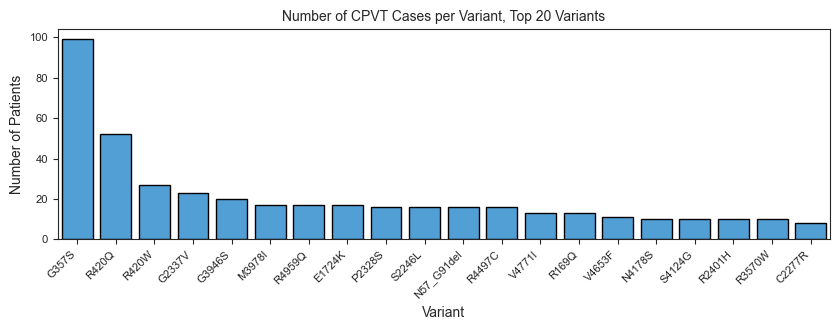

In [51]:
FIG_2_SIZE = (8.5, 3.4)

plt.figure(figsize=FIG_2_SIZE)
sns.barplot(
    data=num_cases_per_mutation,
    x="Variant",
    y="Number of Patients",
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
)
# plt.title("Number of CPVT1 Cases per Variant")
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.tight_layout()  # Adjust layout to make room for the rotated labels

set_figure_size(
    "Variant",
    "Number of Patients",
    "Number of CPVT Cases per Variant, Top 20 Variants",
    x_tick_rotation=45,
    x_tick_ha="right",
)

save_current_plot("num_cases_per_variant")

plt.show()  # Display the plot

In [52]:
## Number of Variants per Exon (Missense variants only since there are fs mutations that basically span the entire gene)
variants_view = pd.read_sql(
    """
    SELECT LOWER(v.exons) AS exon, COUNT(DISTINCT v.variant_id) AS num_variants
    FROM variant_view_mv v
    JOIN individual_variant iv
    ON v.variant_id = iv.variant_id
    WHERE provenance @> jsonb_build_array(jsonb_build_object('dataset_id', 2))
    AND individual_id IN (
        SELECT cpvt.individual_id
        FROM cpvt_patients_v cpvt
    )
    AND LOWER(v.exons) + 1 = UPPER(v.exons)
    AND v.c_edit_type = 'substitution'
    GROUP BY LOWER(v.exons)
    ORDER BY num_variants DESC
    """,
    engine,
)

variants_view.head()

,exon,num_variants
0,90,45
1,47,12
2,8,10
3,14,9
4,94,8


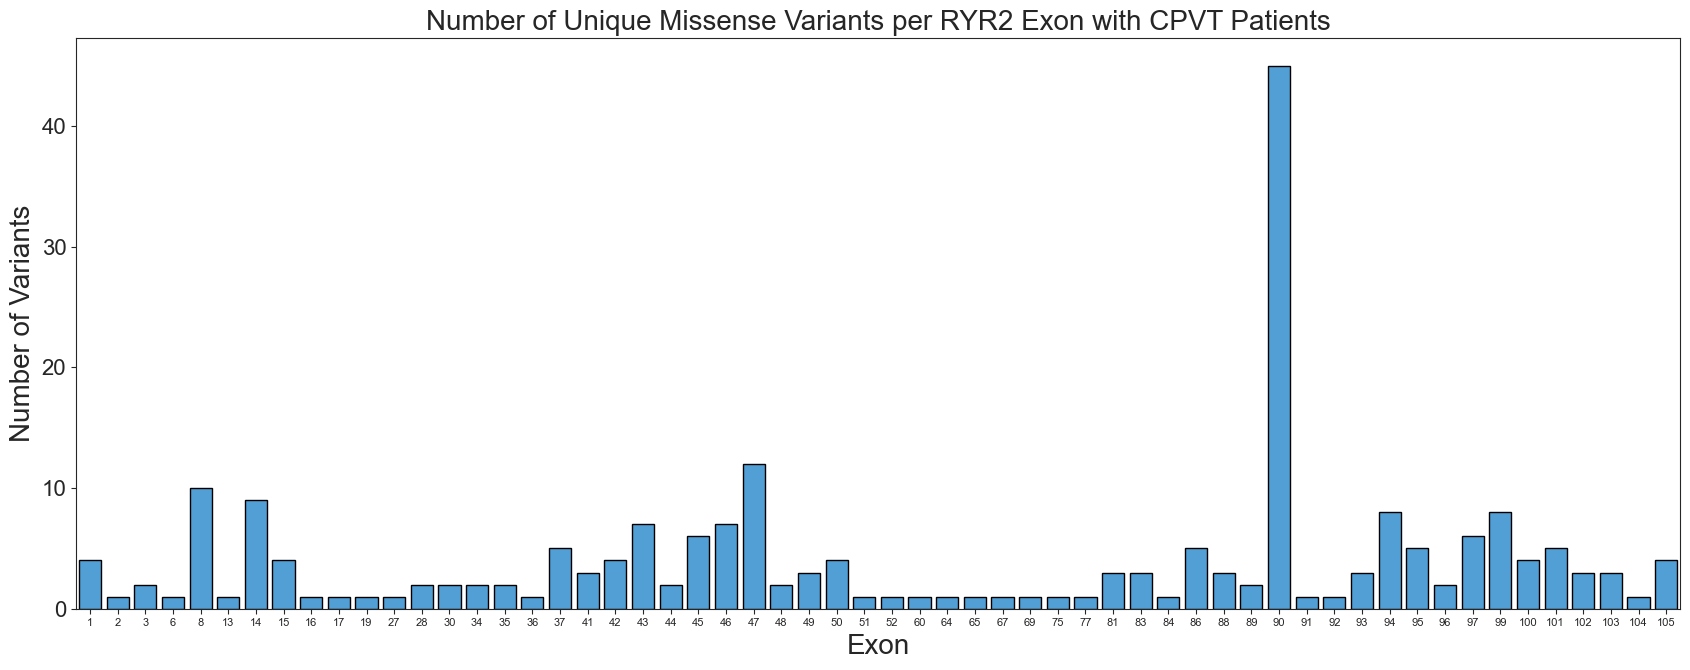

In [53]:
plt.figure(figsize=(
    FIG_2_SIZE[0] * 2, FIG_2_SIZE[1] * 2))  # Double the width and height

# y exons with more than 0 variants
plt_vars = variants_view[variants_view["num_variants"] > 0]

sns.barplot(
    data=variants_view,
    x="exon",
    y="num_variants",
    # palette="pastel",
    # hue='hue',
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
    order=plt_vars["exon"].sort_values(),
)
# plt.title(
#     "Number of Unique Missense Variants per Exon (RYR2) with CPVT1 Patients")
#
# plt.xlabel("Exon")
# plt.ylabel("Number of Variants")
#
# plt.xticks(rotation=90, fontsize=8)  # Rotate labels by 45 degrees
# plt.tight_layout()  # Adjust layout to make room for the rotated labels
#
# for fmt in ["png", "pdf", "svg"]:
#     plt.savefig(
#         os.path.join(figures_dir, f"num_variants_per_exon.{fmt}"), format=fmt,
#         dpi=300
#     )

set_figure_size(
    "Exon",
    "Number of Variants",
    "Number of Unique Missense Variants per RYR2 Exon with CPVT Patients",
    # double the font size
    x_label_fontsize=20,
    y_label_fontsize=20,
    title_fontsize=20,
    y_tick_fontsize=16,
)

save_current_plot("num_variants_per_exon")

plt.show()

# Age of Onset

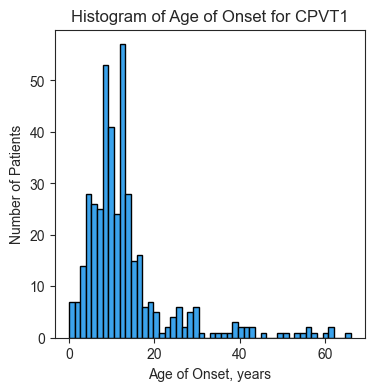

In [54]:
plt.figure(figsize=(4, 4))

# histogram of age of onset
df_all2["age_of_onset::CPVT1"].hist(bins=50,
                                    color=sns.color_palette("husl", 9)[6],
                                    edgecolor="black"

                                    )

plt.title("Histogram of Age of Onset for CPVT1")
plt.xlabel("Age of Onset, years")
plt.ylabel("Number of Patients")

# plt.axvline(median_aoo, color='tab:orange', linestyle='dashed', linewidth=1)
# plt.axvline(mean_aoo, color='tab:red', linestyle='dashed', linewidth=1)
#
# # Add text labels for median and mean
# plt.text(median_aoo, plt.ylim()[1] * 0.95, f'Median: {median_aoo:.2f}',
#          ha='right')
# plt.text(mean_aoo, plt.ylim()[1] * 0.95, f'Mean: {mean_aoo:.2f}',
#          ha='left')

plt.grid(False)

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"hist_age_of_onset.{fmt}"), format=fmt,
        dpi=300
    )

<Axes: xlabel='age_of_onset::CPVT1', ylabel='Density'>

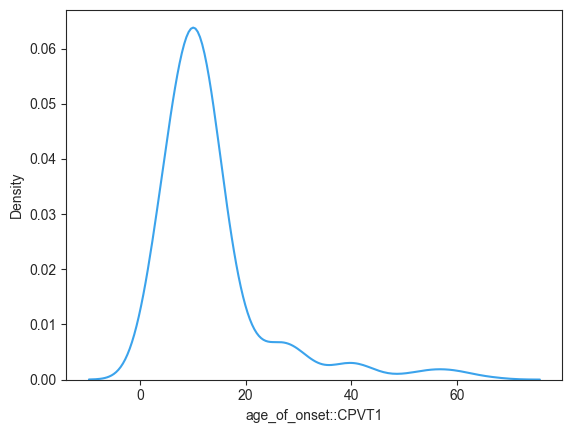

In [55]:
sns.kdeplot(df_all2["age_of_onset::CPVT1"],
            color=sns.color_palette("husl", 9)[6])

In [56]:
# print stats: mean, median, iqr
mean_aoo = df_all2["age_of_onset::CPVT1"].mean()
median_aoo = df_all2["age_of_onset::CPVT1"].median()
q1_aoo = df_all2["age_of_onset::CPVT1"].quantile(0.25)
q3_aoo = df_all2["age_of_onset::CPVT1"].quantile(0.75)

num_with_age_of_onset = df_all2["age_of_onset::CPVT1"].count()

print(
    f"Mean: {mean_aoo:.2f}, Median: {median_aoo:.2f}, IQR: {q1_aoo:.2f}-{q3_aoo:.2f}, n: {num_with_age_of_onset}"
)

Mean: 13.36, Median: 11.00, IQR: 7.00-14.00, n: 411


In [57]:
# calculate skewness and kurtosis
skewness = df_all2["age_of_onset::CPVT1"].skew()
kurtosis = df_all2["age_of_onset::CPVT1"].kurtosis()

print(f"Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}")

Skewness: 2.41, Kurtosis: 6.76


## Age of Onset vs Exon

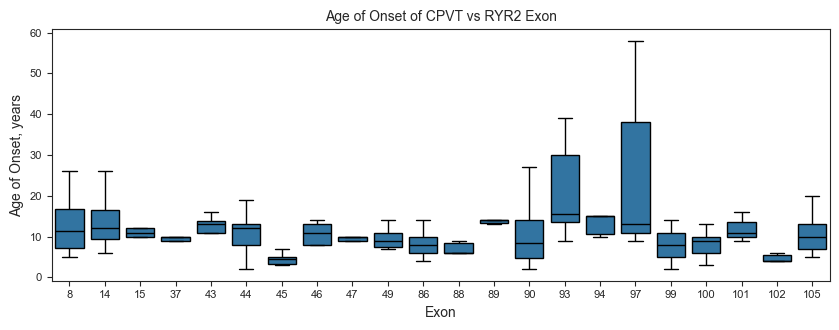

In [58]:
# violin plot of age of onset vs exon
# Create a subplot with custom dimensions

plt.figure(figsize=FIG_2_SIZE)

# Due to the assumption that H has a chi square distribution,
# the number of samples in each group must not be too small. A typical rule is that each sample must have at least 5 measurements.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

MIN_NUM_INDIVIDUALS = 5

# fig, ax = plt.subplots(figsize=(15, 5))
filtered_data = df_all2.dropna(subset=["age_of_onset::CPVT1", "exon"])
# only show exons with more than 5 occurrences
filtered_data = filtered_data[
    filtered_data["exon"].isin(
        filtered_data.value_counts("exon")[
            filtered_data.value_counts("exon") >= MIN_NUM_INDIVIDUALS
            ].index.values
    )
]

ax = sns.boxplot(
    data=filtered_data,
    y="age_of_onset::CPVT1",
    x="exon",
    linewidth=1,
    width=0.8,
    # palette="Set1",
    # hue="exon",
    linecolor="black",
    # color=sns.color_palette("husl", 9)[6],
    showfliers=False,
)

# for violin, alpha in zip(ax.collections[::2], [0.8, 0.6, 0.4, 0.2]):
#     violin.set_alpha(alpha)

# Adjust the inner color alpha of the boxes
# for patch in ax.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, 0.6))  # Set alpha to 0.6

# # Swarm plot on the same axes, with adjusted marker size for better fit
# sns.swarmplot(
#     data=filtered_data,
#     x="exon",
#     y="age_of_onset::CPVT1",
#     color="gray",  # Make swarm dots black for contrast
#     orient="v",
#     size=1.75,
# )

# plt.title("Age of Onset of CPVT1 vs Exon (RYR2)")
# plt.xlabel("Exon")
# plt.ylabel("Age of Onset, years")
#
# plt.grid(False)
#
# plt.tight_layout()
#
# for fmt in ["png", "pdf", "svg"]:
#     plt.savefig(
#         os.path.join(figures_dir, f"age_of_onset_vs_exon_points.{fmt}"),
#         format=fmt,
#         dpi=300,
#     )

set_figure_size(
    "Exon",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Exon",
)

save_current_plot("age_of_onset_vs_exon")

plt.show()

Since these plots basically tell us that the data is not normally distributed, we need to do Kruskal-Wallis instead of ANOVA
to test if the exon location has no effect on the age of onset.

In [59]:
filtered_data.head()

,age_of_onset::CPVT1,hgvs_string,p_hgvs_string,p_edit_type,domain,subdomain,exon
individual_id,,,,,,,
4,2.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
5,10.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
6,2.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
7,10.0,NM_001035.3:c.14174A>G,NP_001026.2:p.(Tyr4725Cys),Substitution,TM,pVSD,99
19,12.0,NM_001035.3:c.7175A>G,NP_001026.2:p.(Tyr2392Cys),Substitution,BSol,BSol1,47


In [60]:
import scipy.stats as stats

age_of_onset_by_exon = filtered_data.groupby("exon")

# Perform the Kruskal-Wallis test
stat_exon, p_exon = stats.kruskal(
    *[group["age_of_onset::CPVT1"] for _, group in age_of_onset_by_exon]
)

print(
    f"Kruskal-Wallis H-test: H={stat_exon:.2f}, P={p_exon:.2g}, dof={len(age_of_onset_by_exon) - 1}, n={len(filtered_data)}")

Kruskal-Wallis H-test: H=70.50, P=2.9e-07, dof=21, n=324


Apparently the exon location does have an effect on the age of onset. Post hoc Dunn test will need to be performed to determine which exons are significantly different.

## Age of Onset vs Domain

In [61]:
# use colors from chimerax

CUSTOM_COLOR_PALLETTE = {
    "ntd": "7C93CB",
    "spry": "F8AE50",
    "jsol": "9F72B2",
    "bsol": "F1EA2E",
    "sclp": "61BC52",
    "csol": "0075BD",
    "taf": "CF5857",
    "tm": "A5A4A5",
    "ctd": "006C39"
}

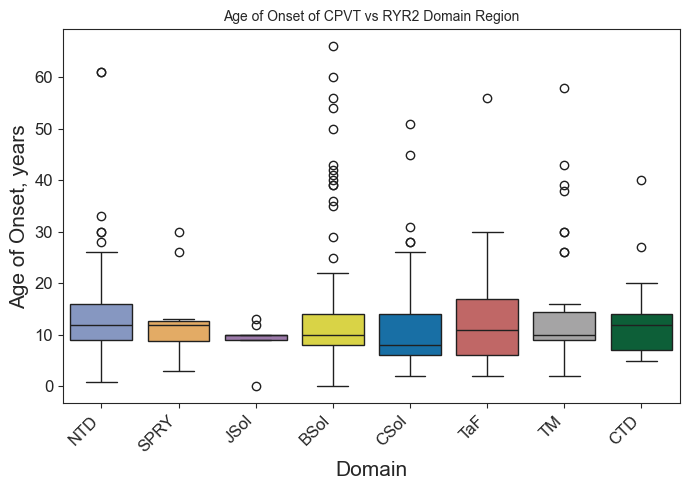

In [62]:
domain_cleaned = df_all2.dropna(subset=["age_of_onset::CPVT1", "domain"])[
    ["age_of_onset::CPVT1", "domain"]
]

domains_with_more_than_5 = (
    domain_cleaned["domain"]
    .value_counts()[
        domain_cleaned["domain"].value_counts() >= MIN_NUM_INDIVIDUALS]
    .index.values
)

domain_cleaned = domain_cleaned[
    domain_cleaned["domain"].isin(domains_with_more_than_5)]

domain_order = [
    v
    for v in domains_df["domains"].dropna().str.strip().values
    if v in set(domains_with_more_than_5)
]

domain_color_mapping = {
    domain: "#" + CUSTOM_COLOR_PALLETTE[domain.lower()]
    for domain in domain_order
}

FIGURE_3_SIZE = (7, 5)

sns.set_style("ticks")
plt.figure(figsize=FIGURE_3_SIZE)

ax = sns.boxplot(
    data=domain_cleaned,
    y="age_of_onset::CPVT1",
    x="domain",
    linewidth=1,
    width=0.8,
    palette=domain_color_mapping,
    hue="domain",
    legend=False,
    order=domain_order,
    # showfliers=False,
)

plt.setp(ax.collections, alpha=.6)

# # Swarm plot on the same axes, with adjusted marker size for better fit
# sns.swarmplot(
#     data=domain_cleaned,
#     x="domain",
#     y="age_of_onset::CPVT1",
#     color="black",  # Make swarm dots black for contrast
#     orient="v",
#     size=2,
#     order=domain_order,
# )

# plt.title("Age of Onset of CPVT vs RYR2 Domain Region")
# plt.xlabel("Domain")
# plt.ylabel("Age of Onset, years")
#
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.grid(False)
# plt.tight_layout()

set_figure_size(
    "Domain",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Domain Region",
    x_tick_rotation=45,
    x_tick_ha="right",
    # set sizes 1.5x bigger for ticks and axes
    x_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    x_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
)

save_current_plot("age_of_onset_vs_domain")

plt.show()

In [63]:
# Perform the Kruskal-Wallis test
stat_domain, p_domain = stats.kruskal(
    *[group["age_of_onset::CPVT1"] for _, group in
      domain_cleaned.groupby("domain")]
)
print(
    f"Kruskal-Wallis H-test: H={stat_domain:.2f}, P={p_domain:.2g}, dof={len(domain_cleaned['domain'].unique()) - 1}, n={len(domain_cleaned)}")

Kruskal-Wallis H-test: H=15.29, P=0.032, dof=7, n=404


## Age of Onset vs Subdomain

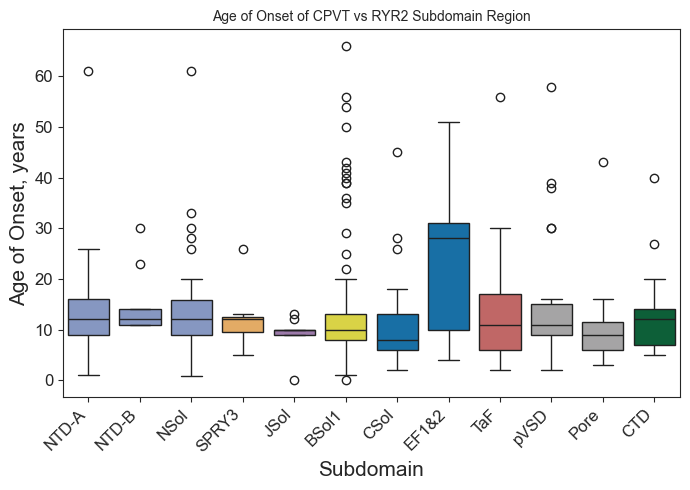

In [64]:
# By Subdomain

subdomain_cleaned = \
    df_all2.dropna(subset=["age_of_onset::CPVT1", "subdomain", ])[
        ["age_of_onset::CPVT1", "subdomain", "domain"]
    ]

subdomains_with_more_than_5 = (
    subdomain_cleaned["subdomain"]
    .value_counts()[
        subdomain_cleaned["subdomain"].value_counts() >= MIN_NUM_INDIVIDUALS
        ]
    .index.values
)

subdomain_cleaned = subdomain_cleaned[
    subdomain_cleaned["subdomain"].isin(subdomains_with_more_than_5)
]

subdomain_order = [
    v
    for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(subdomains_with_more_than_5)
]

subdomain_color_mapping = {
    row["subdomain"]: "#" + CUSTOM_COLOR_PALLETTE[
        row["domain"].lower()
    ]
    for _, row in subdomain_cleaned.iterrows()
}

assert len(subdomain_order) == len(subdomains_with_more_than_5)

plt.figure(figsize=FIGURE_3_SIZE)

ax = sns.boxplot(
    data=subdomain_cleaned,
    y="age_of_onset::CPVT1",
    x="subdomain",
    width=0.8,
    palette=subdomain_color_mapping,
    hue="subdomain",
    legend=False,
    order=subdomain_order,
    # showfliers=False,
)

# plt.setp(ax.collections, alpha=.6)

# Basically same as domains
# sns.swarmplot(
#     data=subdomain_cleaned,
#     x="subdomain",
#     y="age_of_onset::CPVT1",
#     color="black",  # Make swarm dots black for contrast
#     orient="v",
#     size=2,
#     order=subdomain_order,
# )

# plt.title("Age of Onset of CPVT1 vs RyR2 Subdomain Region")
# plt.xlabel("Subdomain")
# plt.ylabel("Age of Onset, years")
#
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.grid(False)
#
# plt.tight_layout()

set_figure_size(
    "Subdomain",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Subdomain Region",
    x_tick_rotation=45,
    x_tick_ha="right",
    x_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    x_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
)

# for fmt in ["png", "pdf", "svg"]:
#     plt.savefig(
#         os.path.join(figures_dir, f"age_of_onset_vs_subdomain.{fmt}"),
#         format=fmt,
#         dpi=300,
#     )

save_current_plot("age_of_onset_vs_subdomain")

plt.show()

In [65]:
# Perform the Kruskal-Wallis test
stat_subdomain, p_subdomain = stats.kruskal(
    *[
        group["age_of_onset::CPVT1"]
        for _, group in subdomain_cleaned.groupby("subdomain")
    ]
)
print(
    f"Kruskal-Wallis H-test: H={stat_subdomain:.2f}, P={p_subdomain:.2g}, dof={len(subdomain_cleaned['subdomain'].unique()) - 1}, n={len(subdomain_cleaned)}")

Kruskal-Wallis H-test: H=27.93, P=0.0033, dof=11, n=393


## Dunn's Test

Since KW test showed that the exon location and domain/subdomain have an effect on the age of onset, we need to perform Dunn's test to determine which exons and domains/subdomains are significantly different.

In [66]:
import scikit_posthocs as sp

In [67]:
# age of onset vs EXON
pvals_exons = sp.posthoc_dunn(
    filtered_data,
    val_col="age_of_onset::CPVT1",
    group_col="exon",
    p_adjust="bonferroni",
)
pvals_exons

,8,14,15,37,43,44,45,46,47,49,...,89,90,93,94,97,99,100,101,102,105
8,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.116725,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.324060,1.0
14,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.012985,1.0,1.000000,1.000000,...,1.000000,0.144614,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.042810,1.0
15,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
37,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
43,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.147181,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.337236,1.0
44,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.989795,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
45,0.116725,0.012985,1.0,1.0,0.147181,0.989795,1.000000,1.0,1.000000,1.000000,...,0.018904,1.000000,0.003620,0.039726,0.126278,1.0,1.000000,0.574686,1.000000,1.0
46,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
47,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.828353,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
49,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.633337,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0


In [68]:
# age of onset vs DOMAIN
pvals_domain = sp.posthoc_dunn(
    domain_cleaned,
    val_col="age_of_onset::CPVT1",
    group_col="domain",
    p_adjust="bonferroni",
)
pvals_domain

,BSol,CSol,CTD,JSol,NTD,SPRY,TM,TaF
BSol,1.000000,0.804261,1.0,1.0,1.000000,1.0,1.0,1.0
CSol,0.804261,1.000000,1.0,1.0,0.004941,1.0,1.0,1.0
CTD,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
JSol,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
NTD,1.000000,0.004941,1.0,1.0,1.000000,1.0,1.0,1.0
SPRY,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
TM,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
TaF,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0


In [69]:
# age of onset vs SUBDOMAIN
pvals_subdomain = sp.posthoc_dunn(
    subdomain_cleaned,
    val_col="age_of_onset::CPVT1",
    group_col="subdomain",
    p_adjust="bonferroni",
)
pvals_subdomain

,BSol1,CSol,CTD,EF1&2,JSol,NSol,NTD-A,NTD-B,Pore,SPRY3,TaF,pVSD
BSol1,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
CSol,1.0,1.000000,1.0,1.0,1.0,0.04209,0.146432,0.373648,1.000000,1.0,1.0,0.208349
CTD,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
EF1&2,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
JSol,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
NSol,1.0,0.042090,1.0,1.0,1.0,1.00000,1.000000,1.000000,0.299520,1.0,1.0,1.000000
NTD-A,1.0,0.146432,1.0,1.0,1.0,1.00000,1.000000,1.000000,0.647152,1.0,1.0,1.000000
NTD-B,1.0,0.373648,1.0,1.0,1.0,1.00000,1.000000,1.000000,0.510236,1.0,1.0,1.000000
Pore,1.0,1.000000,1.0,1.0,1.0,0.29952,0.647152,0.510236,1.000000,1.0,1.0,0.657106
SPRY3,1.0,1.000000,1.0,1.0,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000


## Export for R

Use rstatix to get effect size (export the data to R). Use the r_notebooks/analysis_2.r.ipynb to analyze the data.


In [70]:
filtered_data[[
    "age_of_onset::CPVT1",
    "exon",
]].rename(
    columns={"age_of_onset::CPVT1": "age_of_onset"}
).to_csv(
    os.path.join(figures_dir, "age_of_onset_vs_exon.csv")
)

In [71]:
domain_cleaned[[
    "age_of_onset::CPVT1",
    "domain",
]].rename(
    columns={"age_of_onset::CPVT1": "age_of_onset"}
).to_csv(
    os.path.join(figures_dir, "age_of_onset_vs_domain.csv")
)

In [72]:
subdomain_cleaned[[
    "age_of_onset::CPVT1",
    "subdomain",
]].rename(
    columns={"age_of_onset::CPVT1": "age_of_onset"}
).to_csv(
    os.path.join(figures_dir, "age_of_onset_vs_subdomain.csv")
)

## Significant Differences

In [73]:
# exon
significant_exons = pvals_exons[pvals_exons < 0.05].stack().index

exon_sig_set = set()
sig_exon_set = set()
for e1, e2 in significant_exons:
    sig_exons = (min(e1, e2), max(e1, e2))

    if sig_exons in exon_sig_set:
        continue

    exon_sig_set.add(sig_exons)
    sig_exon_set.add(e1)
    sig_exon_set.add(e2)
    print(f"{e1} vs {e2}, p={pvals_exons.loc[e1, e2]:.2g}")

14 vs 45, p=0.013
14 vs 102, p=0.043
45 vs 89, p=0.019
45 vs 93, p=0.0036
45 vs 94, p=0.04
89 vs 102, p=0.046
93 vs 102, p=0.01


In [74]:
# domain
significant_domains = pvals_domain[pvals_domain < 0.05].stack().index
for d1, d2 in significant_domains:
    print(f"{d1} vs {d2}, p={pvals_domain.loc[d1, d2]:.2g}")

CSol vs NTD, p=0.0049
NTD vs CSol, p=0.0049


In [75]:
# subdomain
significant_subdomains = pvals_subdomain[pvals_subdomain < 0.05].stack().index
for d1, d2 in significant_subdomains:
    print(f"{d1} vs {d2}, p={pvals_subdomain.loc[d1, d2]:.2g}")

CSol vs NSol, p=0.042
NSol vs CSol, p=0.042


For domains, it seems that the CSol and NTD domains are significantly different from each other.
We will take a look at the median age of onset and the IQRs for these two domains.

FOr the subdomains, the CSol and the NSol are significantly different from each other.
Again, we will take a look at the median age of onset and the IQRs for these two subdomains.

In [76]:
def get_median_and_mean(df_calc: pd.DataFrame):
    # NOTE: DUNN only tests if means are different, NOT medians!!!
    mean = df_calc["age_of_onset::CPVT1"].mean()
    median = df_calc["age_of_onset::CPVT1"].median()
    q1 = df_calc["age_of_onset::CPVT1"].quantile(0.25)
    q3 = df_calc["age_of_onset::CPVT1"].quantile(0.75)

    return mean, median, q1, q3


def print_median_and_iqr(df_calc: pd.DataFrame, name: str):
    mean, median, q1, q3 = get_median_and_mean(df_calc)

    print(
        f"{name}: mean={mean:.2f}, median={median:.2f}, IQR={q1:.2f}-{q3:.2f}, n={len(df_calc)}"
    )

In [77]:
# EXONS:
for exon in sig_exon_set:
    exon_df = filtered_data[filtered_data["exon"] == exon]

    print_median_and_iqr(exon_df, f"Exon {exon}")

Exon 102: mean=5.17, median=4.00, IQR=4.00-5.50, n=6
Exon 45: mean=4.50, median=4.50, IQR=3.25-5.00, n=6
Exon 14: mean=14.57, median=12.00, IQR=9.50-16.50, n=47
Exon 89: mean=16.00, median=14.00, IQR=13.25-14.00, n=6
Exon 93: mean=20.62, median=15.50, IQR=13.50-30.00, n=8
Exon 94: mean=13.25, median=15.00, IQR=10.75-15.00, n=8


In [78]:
# print for every exon
for exon in filtered_data["exon"].unique():
    exon_df = filtered_data[filtered_data["exon"] == exon]

    print_median_and_iqr(exon_df, f"Exon {exon}")

Exon 99: mean=11.62, median=8.00, IQR=5.00-11.00, n=8
Exon 47: mean=9.48, median=10.00, IQR=9.00-10.00, n=21
Exon 8: mean=13.71, median=11.50, IQR=7.25-16.75, n=34
Exon 100: mean=8.20, median=9.00, IQR=6.00-10.00, n=10
Exon 101: mean=11.86, median=11.00, IQR=10.00-13.50, n=7
Exon 49: mean=8.36, median=9.00, IQR=7.50-11.00, n=11
Exon 46: mean=13.27, median=11.00, IQR=8.00-13.00, n=11
Exon 45: mean=4.50, median=4.50, IQR=3.25-5.00, n=6
Exon 43: mean=15.50, median=13.00, IQR=11.00-13.75, n=8
Exon 14: mean=14.57, median=12.00, IQR=9.50-16.50, n=47
Exon 90: mean=11.58, median=8.50, IQR=4.75-14.00, n=56
Exon 44: mean=10.62, median=12.00, IQR=8.00-13.00, n=13
Exon 105: mean=12.50, median=10.00, IQR=7.00-13.00, n=18
Exon 93: mean=20.62, median=15.50, IQR=13.50-30.00, n=8
Exon 15: mean=10.32, median=11.00, IQR=10.00-12.00, n=6
Exon 86: mean=8.36, median=8.00, IQR=6.00-10.00, n=11
Exon 89: mean=16.00, median=14.00, IQR=13.25-14.00, n=6
Exon 102: mean=5.17, median=4.00, IQR=4.00-5.50, n=6
Exon 97

In [79]:
# print lowest, highest by median
exon_medians_list = [
    {
        "exon": exon,
        "median": exon_df["age_of_onset::CPVT1"].median(),
        "mean": exon_df["age_of_onset::CPVT1"].mean(),
        "n": len(exon_df),
        "q1": exon_df["age_of_onset::CPVT1"].quantile(0.25),
        "q3": exon_df["age_of_onset::CPVT1"].quantile(0.75),
    } for exon, exon_df in filtered_data.groupby("exon")
]

exon_medians_df = pd.DataFrame(exon_medians_list)
exon_medians_df.sort_values("median", inplace=True)
exon_medians_df

,exon,median,mean,n,q1,q3
20,102,4.0,5.166667,6,4.00,5.50
6,45,4.5,4.500000,6,3.25,5.00
11,88,6.0,8.066667,15,6.00,8.50
10,86,8.0,8.363636,11,6.00,10.00
17,99,8.0,11.625000,8,5.00,11.00
13,90,8.5,11.580357,56,4.75,14.00
9,49,9.0,8.363636,11,7.50,11.00
18,100,9.0,8.200000,10,6.00,10.00
21,105,10.0,12.500000,18,7.00,13.00
3,37,10.0,9.236667,9,9.00,10.00


In [80]:
csol_domain = domain_cleaned[domain_cleaned["domain"] == "CSol"]

print_median_and_iqr(csol_domain, "CSol")

CSol: mean=10.79, median=8.00, IQR=6.00-14.00, n=75


In [81]:
ntd_domain = domain_cleaned[domain_cleaned["domain"] == "NTD"]

print_median_and_iqr(ntd_domain, "NTD")

NTD: mean=13.88, median=12.00, IQR=9.00-16.00, n=105


In [82]:
# SUBDOMAIN
csol_subdomain = subdomain_cleaned[subdomain_cleaned["subdomain"] == "CSol"]

print_median_and_iqr(csol_subdomain, "CSol (Subdomain)")

CSol (Subdomain): mean=9.79, median=8.00, IQR=6.00-13.00, n=70


In [83]:
nsol_subdomain = subdomain_cleaned[subdomain_cleaned["subdomain"] == "NSol"]

print_median_and_iqr(nsol_subdomain, "NSol (Subdomain)")

NSol (Subdomain): mean=14.00, median=12.00, IQR=9.00-15.75, n=50


# Export Data


In [84]:
# export the age of osnet by domain and subdomain into a csv
domain_median_list = [
    {
        "domain": domain,
        "median": domain_df["age_of_onset::CPVT1"].median(),
        "mean": domain_df["age_of_onset::CPVT1"].mean(),
        "n": len(domain_df),
        "q1": domain_df["age_of_onset::CPVT1"].quantile(0.25),
        "q3": domain_df["age_of_onset::CPVT1"].quantile(0.75),
    } for domain, domain_df in domain_cleaned.groupby("domain")
]

domain_median_df = pd.DataFrame(domain_median_list)
domain_median_df.sort_values([
    "median", "mean", "n"
], inplace=True)
domain_median_df.head()

,domain,median,mean,n,q1,q3
1,CSol,8.0,10.793333,75,6.0,14.0
3,JSol,10.0,9.236667,9,9.0,10.0
6,TM,10.0,13.095238,63,9.0,14.5
0,BSol,10.0,15.173913,92,8.0,14.0
7,TaF,11.0,13.833333,24,6.0,17.0


In [85]:
domain_median_df.to_csv(
    os.path.join(figures_dir, "age_of_onset_vs_domain_median.csv"),
    index=False
)

In [86]:
subdomain_median_list = [
    {
        "subdomain": subdomain,
        "median": subdomain_df["age_of_onset::CPVT1"].median(),
        "mean": subdomain_df["age_of_onset::CPVT1"].mean(),
        "n": len(subdomain_df),
        "q1": subdomain_df["age_of_onset::CPVT1"].quantile(0.25),
        "q3": subdomain_df["age_of_onset::CPVT1"].quantile(0.75),
    } for subdomain, subdomain_df in subdomain_cleaned.groupby("subdomain")
]

subdomain_median_df = pd.DataFrame(subdomain_median_list)
subdomain_median_df.sort_values([
    "median", "mean", "n"
], inplace=True)
subdomain_median_df.head()

,subdomain,median,mean,n,q1,q3
1,CSol,8.0,9.792857,70,6.0,13.0
8,Pore,9.0,9.814815,27,6.0,11.5
4,JSol,10.0,9.236667,9,9.0,10.0
0,BSol1,10.0,14.633333,90,8.0,13.0
10,TaF,11.0,13.833333,24,6.0,17.0


In [87]:
subdomain_median_df.to_csv(
    os.path.join(figures_dir, "age_of_onset_vs_subdomain_median.csv"),
    index=False
)

# Age of onset vs Year Published

Although not in the original manuscript, many people have commented on the possibility that the age of onset may be affected by the year of the paper being written as we have better diagonis vs the past.

Therefore, we would expect to see some sort of negative correlation between the year of the paper and the age of onset.

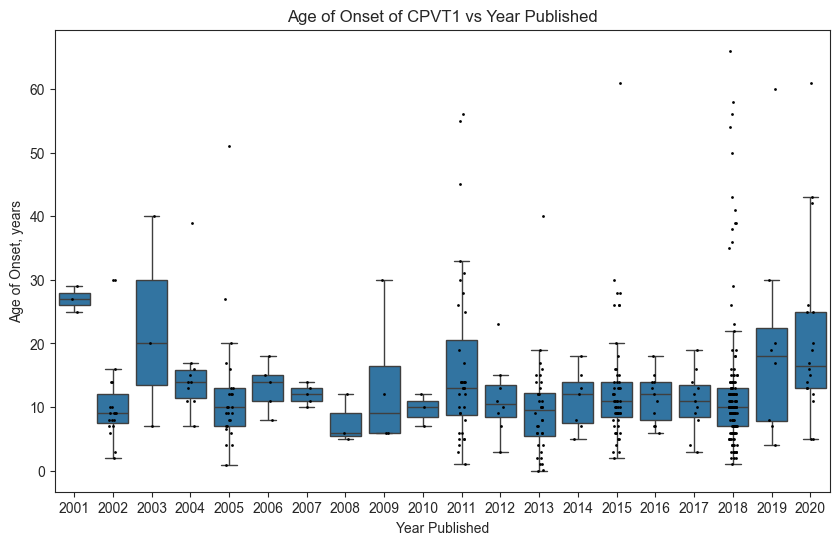

In [88]:
# plot age of onset vs year
plt.figure(figsize=(10, 6))

df_aoo_vs_year = df_all.dropna(
    subset=["year",
            "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1"]
).rename(
    columns={
        "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1": "age_of_onset::CPVT1"
    }
)[[
    "year",
    "age_of_onset::CPVT1"
]]

df_aoo_vs_year["year"] = df_aoo_vs_year["year"].astype(int)

sns.stripplot(data=df_aoo_vs_year, x="year", y="age_of_onset::CPVT1",
              color="black", size=2)

sns.boxplot(
    data=df_aoo_vs_year,
    x="year",
    y="age_of_onset::CPVT1",
    linewidth=1,
    showfliers=False,
)

plt.title("Age of Onset of CPVT1 vs Year Published")
plt.xlabel("Year Published")
plt.ylabel("Age of Onset, years")

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"age_of_onset_vs_year.{fmt}"),
        format=fmt,
        dpi=300,
    )

plt.show()

In [89]:
# calculate the correlation coefficient
df_aoo_vs_year.corr()

,year,age_of_onset::CPVT1
year,1.000000,0.023093
age_of_onset::CPVT1,0.023093,1.000000


Basically there is no correlation between the year of the paper and the age of onset. (pearson's r = 0.023) - basically like 0, and somehow its slightly positive so somehow we are catching older patients in the newer papers.